In [9]:
"Run this if you want to use google colab"
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
"Incase you don't have these."
!pip install simclr
!pip install lightning-flash
!pip install timm
!pip install torchtyping

"Download imagenette2.tgz from the link in our github repo. Add imagenette2.tgz inside your google drive."
"Uncomment if you want to use google colab"
!tar -xvzf /content/drive/MyDrive/imagenette2.tgz

Utdata för streaming har trunkerats till de sista 5000 raderna.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n03888257/n0388

In [1]:
import cv2
import os
import pathlib
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms

from flash.core.optimizers import LARS

from scipy.stats import ortho_group
from simclr.modules.transformations import TransformsSimCLR
from simclr.modules import NT_Xent
from simclr.modules.identity import Identity
from simclr.modules import LogisticRegression

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchtyping import TensorType, patch_typeguard
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import Callable, Iterator, Dict
from typeguard import typechecked

from matplotlib import pyplot as plt
from torch import linalg as LA
from tqdm import tqdm as tqdm

from timm.data import ImageDataset
from timm.data.transforms_factory import create_transform
from timm.data import create_dataset

patch_typeguard()  # use before @typechecked

In [2]:
class SimCLR(nn.Module):

    def __init__(self, encoder, projection_dim, n_features):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = n_features

        self.encoder.fc = Identity()
        
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False, device = DEVICE),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False, device = DEVICE),
        )

    def forward(self, x_i, x_j):
        
        
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)
        
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        
        x_i = self.encoder.conv1(x_i)
        x_i = self.encoder.bn1(x_i)
        x_i = self.encoder.relu(x_i)
        x_i = self.encoder.maxpool(x_i)
        
        #Extract the features from intermediate layers
        h_1 = self.encoder.layer1(x_i)
        h_2 = self.encoder.layer2(h_1)
        h_3 = self.encoder.layer3(h_2)
        h_4 = self.encoder.layer4(h_3)
        
        h_1.norm(dim = 1, p = 2)
        h_2.norm(dim = 1, p = 2)
        h_3.norm(dim = 1, p = 2)
        h_4.norm(dim = 1, p = 2)
        
        return h_i, h_j, z_i, z_j, h_1, h_2, h_3, h_4

In [3]:
image_size = 448
batch_size = 2
global_step = 0
epochs = 100
temperature = 0.2
projection_dim = 128 #128 for imagenette, 64 for CIFAR10
lr = 0.075 * np.sqrt(batch_size)
weight_decay = 1e-6
epoch_num = 100
n_classes = 2

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()
torch.manual_seed(43)

In [5]:
"Code below loads the imagenette data set."
tim_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

imagenette_ds_train = create_dataset(name = '', root = 'imagenette2',
                                    transform = TransformsSimCLR(size = image_size))

imagenette_ds_test = create_dataset(name = '', root = 'imagenette2', 
                                    transform = tim_transform)

tim_trainloader = torch.utils.data.DataLoader(
    imagenette_ds_train,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

tim_testloader = torch.utils.data.DataLoader(
    imagenette_ds_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

"Code below takes a subset of the imagenette."
imagenet_ds_train = create_dataset(name = '', root = 'imagenetmini',
                                    transform = TransformsSimCLR(size = image_size))

imagenet_ds_test = create_dataset(name = '', root = 'imagenetmini', 
                                    transform = tim_transform)

img_trainloader = torch.utils.data.DataLoader(
    imagenet_ds_train,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

img_testloader = torch.utils.data.DataLoader(
    imagenet_ds_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

In [19]:
#from resnet_wider import resnet50x2
from resnet import get_resnet


encoder, _= get_resnet(50, width_multiplier = 2, sk_ratio = 0.0625)
pth_path = 'r50_2x_sk1_ema.pth'
#encoder.load_state_dict(torch.load(pth_path)['resnet'])
encoder.to(DEVICE)


#encoder = resnet50x2()
#sd = torch.load('resnet50-2x.pth', map_location=DEVICE)
#encoder.load_state_dict(sd['state_dict'])

#n_features = encoder.fc.in_features  # get dimensions of last fully-connected layer
#model = SimCLR(encoder, projection_dim, n_features).to(DEVICE)

ResNet(
  (pre): Sequential(
    (0): Stem(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNormRelu(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNormRelu(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNormRelu(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (layer1): Blocks(
    (blocks): ModuleList(
      (0): BottleneckBlock(
        (projection): Projection(
          (shortcut): Sequential(
         

In [20]:
for x, y in img_testloader:
    x = x.to(DEVICE)
    with torch.no_grad():
        x1, x2, x3, x4 = encoder(x)
    print(x1)
    break

tensor([[[[0.2887, 0.7960, 2.6135,  ..., 0.6734, 1.0205, 0.2422],
          [2.0138, 1.4652, 2.2992,  ..., 4.5096, 0.5101, 1.2151],
          [1.5480, 0.8226, 2.1142,  ..., 0.7278, 0.9922, 1.2407],
          ...,
          [0.6991, 1.0615, 0.1379,  ..., 0.8361, 1.1851, 0.0000],
          [0.2503, 0.2760, 0.6891,  ..., 2.3459, 2.8523, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4929, 0.0000]],

         [[0.1615, 0.0000, 1.4250,  ..., 0.9534, 1.1213, 0.4198],
          [0.0000, 0.0000, 0.0000,  ..., 0.6759, 0.0000, 0.0000],
          [0.5541, 0.0000, 0.0000,  ..., 0.8211, 1.7075, 0.5512],
          ...,
          [0.5526, 0.0000, 0.0000,  ..., 2.1835, 0.0000, 0.5297],
          [0.6328, 0.0000, 0.0000,  ..., 1.6960, 0.4466, 0.0416],
          [0.0000, 0.0000, 0.0000,  ..., 1.0710, 2.2461, 0.7161]],

         [[0.2105, 3.1385, 1.8519,  ..., 1.1052, 2.5203, 2.0471],
          [0.9180, 0.8739, 0.2047,  ..., 0.3933, 0.0000, 0.0000],
          [0.6525, 0.1448, 1.2603,  ..., 2

In [ ]:
optimizer = LARS(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = NT_Xent(batch_size, temperature = temperature, world_size=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       epochs, 
                                                       eta_min=0, 
                                                       last_epoch=-1)

In [7]:
def train(global_step, loader, model, criterion, optimizer, writer):
    loss_epoch = 0
    for steps, ((x_i, x_j), _) in enumerate(loader):
        x_i = x_i.to(DEVICE)
        x_j = x_j.to(DEVICE)
        
        optimizer.zero_grad()
        h_i, h_j, z_i, z_j, h_1, h_2, h_3, h_4 = model(x_i, x_j)

        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()

        if steps % 50 == 0:
            print(f"Step [{steps}/{len(loader)}]\t Loss: {loss.item()}")

        writer.add_scalar("Loss/train_epoch", loss.item(), global_step)
        loss_epoch += loss.item()
        global_step += 1
    return loss_epoch

In [14]:
"Run this cell if you want to train the model."
for epoch in tqdm(range(epochs)):
    loss_epoch = train(global_step, img_trainloader, model, criterion, optimizer, writer)
    scheduler.step()
    writer.add_scalar("Loss/train", loss_epoch / len(img_trainloader), epoch)
    print(
        f"Epoch [{epoch}/{epochs}]\t Loss: {loss_epoch / len(img_trainloader)}\t"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Step [0/50]	 Loss: 1.1103450059890747


  1%|          | 1/100 [00:34<56:43, 34.38s/it]

Epoch [0/100]	 Loss: 1.103788845539093	
Step [0/50]	 Loss: 0.9975297451019287


  2%|▏         | 2/100 [00:46<35:09, 21.52s/it]

Epoch [1/100]	 Loss: 1.0532992660999299	
Step [0/50]	 Loss: 0.8938459157943726


  3%|▎         | 3/100 [00:58<27:33, 17.05s/it]

Epoch [2/100]	 Loss: 0.9410865265130997	
Step [0/50]	 Loss: 2.6201157569885254


  4%|▍         | 4/100 [01:10<23:54, 14.95s/it]

Epoch [3/100]	 Loss: 1.3117121028900147	
Step [0/50]	 Loss: 0.9722167253494263


  5%|▌         | 5/100 [01:23<22:29, 14.20s/it]

Epoch [4/100]	 Loss: 1.056481723561883	
Step [0/50]	 Loss: 0.5246982574462891


  6%|▌         | 6/100 [01:35<20:59, 13.40s/it]

Epoch [5/100]	 Loss: 1.4489745111763477	
Step [0/50]	 Loss: 0.14414136111736298


  7%|▋         | 7/100 [01:47<20:03, 12.94s/it]

Epoch [6/100]	 Loss: 1.535931943547912	
Step [0/50]	 Loss: 4.569141864776611


  8%|▊         | 8/100 [01:59<19:32, 12.74s/it]

Epoch [7/100]	 Loss: 2.3937590044620447	
Step [0/50]	 Loss: 0.20433926582336426


  9%|▉         | 9/100 [02:16<21:15, 14.02s/it]

Epoch [8/100]	 Loss: 2.691045815623365	
Step [0/50]	 Loss: 3.170926332473755


 10%|█         | 10/100 [02:28<20:06, 13.41s/it]

Epoch [9/100]	 Loss: 1.9528595398087054	
Step [0/50]	 Loss: 1.2580846548080444


 11%|█         | 11/100 [02:40<19:19, 13.02s/it]

Epoch [10/100]	 Loss: 2.25842614187859	
Step [0/50]	 Loss: 0.0020922240801155567


 12%|█▏        | 12/100 [02:52<18:42, 12.76s/it]

Epoch [11/100]	 Loss: 3.1078147806867493	
Step [0/50]	 Loss: 7.970776081085205


 13%|█▎        | 13/100 [03:04<18:14, 12.57s/it]

Epoch [12/100]	 Loss: 3.3410904536372983	
Step [0/50]	 Loss: 0.0001703653542790562


 14%|█▍        | 14/100 [03:17<18:05, 12.63s/it]

Epoch [13/100]	 Loss: 4.0225309249051495	
Step [0/50]	 Loss: 0.00019721229909919202


 15%|█▌        | 15/100 [03:29<17:48, 12.57s/it]

Epoch [14/100]	 Loss: 3.751061408091482	
Step [0/50]	 Loss: 0.0005579797434620559


 16%|█▌        | 16/100 [03:43<17:54, 12.80s/it]

Epoch [15/100]	 Loss: 4.312708017031546	
Step [0/50]	 Loss: 0.003144808579236269


 17%|█▋        | 17/100 [03:55<17:29, 12.65s/it]

Epoch [16/100]	 Loss: 3.250445004251378	
Step [0/50]	 Loss: 0.00020254586706869304


 18%|█▊        | 18/100 [04:07<17:09, 12.55s/it]

Epoch [17/100]	 Loss: 3.6648457287510974	
Step [0/50]	 Loss: 0.00013758783461526036


 19%|█▉        | 19/100 [04:20<16:52, 12.50s/it]

Epoch [18/100]	 Loss: 4.212395872220659	
Step [0/50]	 Loss: 9.501726150512695


 20%|██        | 20/100 [04:32<16:40, 12.51s/it]

Epoch [19/100]	 Loss: 3.2814860295385007	
Step [0/50]	 Loss: 0.00013574030890595168


 21%|██        | 21/100 [04:46<16:53, 12.83s/it]

Epoch [20/100]	 Loss: 3.8582086530639206	
Step [0/50]	 Loss: 0.0004251525388099253


 22%|██▏       | 22/100 [04:59<16:54, 13.01s/it]

Epoch [21/100]	 Loss: 4.081196816186857	
Step [0/50]	 Loss: 3.2258238792419434


 23%|██▎       | 23/100 [05:12<16:28, 12.84s/it]

Epoch [22/100]	 Loss: 3.237916244260559	
Step [0/50]	 Loss: 7.643374919891357


 24%|██▍       | 24/100 [05:24<16:05, 12.71s/it]

Epoch [23/100]	 Loss: 3.653742373599089	
Step [0/50]	 Loss: 1.000740885734558


 25%|██▌       | 25/100 [05:37<15:47, 12.64s/it]

Epoch [24/100]	 Loss: 2.379547295673401	
Step [0/50]	 Loss: 0.0001774272823240608


 26%|██▌       | 26/100 [05:49<15:33, 12.61s/it]

Epoch [25/100]	 Loss: 3.647066901966464	
Step [0/50]	 Loss: 0.0006788288010284305


 27%|██▋       | 27/100 [06:02<15:15, 12.54s/it]

Epoch [26/100]	 Loss: 4.228954359282507	
Step [0/50]	 Loss: 2.656703472137451


 28%|██▊       | 28/100 [06:14<15:04, 12.56s/it]

Epoch [27/100]	 Loss: 2.6714419518230716	
Step [0/50]	 Loss: 0.00023058375518303365


 29%|██▉       | 29/100 [06:28<15:12, 12.85s/it]

Epoch [28/100]	 Loss: 3.5332426676145405	
Step [0/50]	 Loss: 0.0002257568994536996


 30%|███       | 30/100 [06:40<14:51, 12.73s/it]

Epoch [29/100]	 Loss: 3.408607006527163	
Step [0/50]	 Loss: 8.97781753540039


 31%|███       | 31/100 [06:53<14:33, 12.65s/it]

Epoch [30/100]	 Loss: 4.160689197882021	
Step [0/50]	 Loss: 0.00013222411507740617


 32%|███▏      | 32/100 [07:05<14:16, 12.60s/it]

Epoch [31/100]	 Loss: 4.182200397012784	
Step [0/50]	 Loss: 7.930345058441162


 33%|███▎      | 33/100 [07:17<14:01, 12.56s/it]

Epoch [32/100]	 Loss: 2.0399088727415076	
Step [0/50]	 Loss: 0.0035601360723376274


 34%|███▍      | 34/100 [07:30<13:47, 12.55s/it]

Epoch [33/100]	 Loss: 2.52871354584815	
Step [0/50]	 Loss: 2.900604486465454


 35%|███▌      | 35/100 [07:43<13:51, 12.79s/it]

Epoch [34/100]	 Loss: 2.7218791607627644	
Step [0/50]	 Loss: 0.21374434232711792


 36%|███▌      | 36/100 [07:56<13:32, 12.69s/it]

Epoch [35/100]	 Loss: 2.5448437974462284	
Step [0/50]	 Loss: 4.316364765167236


 37%|███▋      | 37/100 [08:08<13:14, 12.61s/it]

Epoch [36/100]	 Loss: 2.96317721111438	
Step [0/50]	 Loss: 0.0008182739838957787


 38%|███▊      | 38/100 [08:21<12:58, 12.55s/it]

Epoch [37/100]	 Loss: 2.4014415505134092	
Step [0/50]	 Loss: 0.06276755779981613


 39%|███▉      | 39/100 [08:33<12:44, 12.53s/it]

Epoch [38/100]	 Loss: 2.460280799716129	
Step [0/50]	 Loss: 3.521265983581543


 40%|████      | 40/100 [08:46<12:29, 12.49s/it]

Epoch [39/100]	 Loss: 2.9038283320722984	
Step [0/50]	 Loss: 0.0009681266965344548


 41%|████      | 41/100 [08:58<12:22, 12.58s/it]

Epoch [40/100]	 Loss: 2.3475801257928834	
Step [0/50]	 Loss: 7.398604393005371


 42%|████▏     | 42/100 [09:12<12:20, 12.77s/it]

Epoch [41/100]	 Loss: 2.856257142397226	
Step [0/50]	 Loss: 6.3220930099487305


 43%|████▎     | 43/100 [09:24<12:01, 12.67s/it]

Epoch [42/100]	 Loss: 1.7793100734140899	
Step [0/50]	 Loss: 0.00045765069080516696


 44%|████▍     | 44/100 [09:36<11:45, 12.60s/it]

Epoch [43/100]	 Loss: 2.6601539095601767	
Step [0/50]	 Loss: 0.0017242663307115436


 45%|████▌     | 45/100 [09:49<11:30, 12.55s/it]

Epoch [44/100]	 Loss: 1.7687551090113993	
Step [0/50]	 Loss: 0.00036206215736456215


 46%|████▌     | 46/100 [10:01<11:16, 12.53s/it]

Epoch [45/100]	 Loss: 2.527946132090583	
Step [0/50]	 Loss: 0.00020433362806215882


 47%|████▋     | 47/100 [10:14<11:02, 12.50s/it]

Epoch [46/100]	 Loss: 2.065088328220736	
Step [0/50]	 Loss: 3.0974960327148438


 48%|████▊     | 48/100 [10:28<11:22, 13.12s/it]

Epoch [47/100]	 Loss: 2.717078245148441	
Step [0/50]	 Loss: 5.7033257484436035


 49%|████▉     | 49/100 [10:41<10:59, 12.93s/it]

Epoch [48/100]	 Loss: 2.8137413152372757	
Step [0/50]	 Loss: 4.244714736938477


 50%|█████     | 50/100 [10:53<10:39, 12.79s/it]

Epoch [49/100]	 Loss: 3.11925697194878	
Step [0/50]	 Loss: 9.082030296325684


 51%|█████     | 51/100 [11:06<10:22, 12.69s/it]

Epoch [50/100]	 Loss: 2.682609902022814	
Step [0/50]	 Loss: 0.02898850478231907


 52%|█████▏    | 52/100 [11:18<10:05, 12.62s/it]

Epoch [51/100]	 Loss: 2.5955968675731858	
Step [0/50]	 Loss: 6.3337812423706055


 53%|█████▎    | 53/100 [11:31<09:52, 12.60s/it]

Epoch [52/100]	 Loss: 3.355112848427234	
Step [0/50]	 Loss: 0.00013740906433667988


 54%|█████▍    | 54/100 [11:44<09:49, 12.82s/it]

Epoch [53/100]	 Loss: 3.490821079241723	
Step [0/50]	 Loss: 0.00013723026495426893


 55%|█████▌    | 55/100 [11:57<09:32, 12.72s/it]

Epoch [54/100]	 Loss: 2.2699446767306655	
Step [0/50]	 Loss: 0.00021312315948307514


 56%|█████▌    | 56/100 [12:09<09:15, 12.62s/it]

Epoch [55/100]	 Loss: 3.153363104999444	
Step [0/50]	 Loss: 4.155941963195801


 57%|█████▋    | 57/100 [12:21<08:59, 12.56s/it]

Epoch [56/100]	 Loss: 2.7564627251772618	
Step [0/50]	 Loss: 0.4780236482620239


 58%|█████▊    | 58/100 [12:34<08:46, 12.52s/it]

Epoch [57/100]	 Loss: 2.967714199216425	
Step [0/50]	 Loss: 0.00015206968237180263


 59%|█████▉    | 59/100 [12:46<08:33, 12.52s/it]

Epoch [58/100]	 Loss: 3.168575805261935	
Step [0/50]	 Loss: 8.561319351196289


 60%|██████    | 60/100 [12:59<08:19, 12.50s/it]

Epoch [59/100]	 Loss: 3.3205237380779	
Step [0/50]	 Loss: 0.00013582974497694522


 61%|██████    | 61/100 [13:12<08:16, 12.74s/it]

Epoch [60/100]	 Loss: 2.3883670479019927	
Step [0/50]	 Loss: 0.00016056197637226433


 62%|██████▏   | 62/100 [13:25<08:00, 12.66s/it]

Epoch [61/100]	 Loss: 2.339025238438044	
Step [0/50]	 Loss: 2.703249454498291


 63%|██████▎   | 63/100 [13:37<07:45, 12.59s/it]

Epoch [62/100]	 Loss: 3.1350498230426456	
Step [0/50]	 Loss: 9.642536163330078


 64%|██████▍   | 64/100 [13:49<07:31, 12.54s/it]

Epoch [63/100]	 Loss: 2.989130640311487	
Step [0/50]	 Loss: 0.0018495001131668687


 65%|██████▌   | 65/100 [14:02<07:18, 12.53s/it]

Epoch [64/100]	 Loss: 2.7257222157871	
Step [0/50]	 Loss: 0.0005716814193874598


 66%|██████▌   | 66/100 [14:14<07:04, 12.48s/it]

Epoch [65/100]	 Loss: 2.258770698994922	
Step [0/50]	 Loss: 0.0001611281477380544


 67%|██████▋   | 67/100 [14:28<07:00, 12.74s/it]

Epoch [66/100]	 Loss: 1.9726255258916354	
Step [0/50]	 Loss: 0.00014175957767292857


 68%|██████▊   | 68/100 [14:40<06:45, 12.67s/it]

Epoch [67/100]	 Loss: 1.9345480819619842	
Step [0/50]	 Loss: 9.797399520874023


 69%|██████▉   | 69/100 [14:53<06:32, 12.68s/it]

Epoch [68/100]	 Loss: 2.5203447646822315	
Step [0/50]	 Loss: 9.367280960083008


 70%|███████   | 70/100 [15:08<06:44, 13.49s/it]

Epoch [69/100]	 Loss: 2.4988367588058464	
Step [0/50]	 Loss: 0.0036959876306355


 71%|███████   | 71/100 [15:21<06:22, 13.20s/it]

Epoch [70/100]	 Loss: 1.8704423436736397	
Step [0/50]	 Loss: 0.028026267886161804


 72%|███████▏  | 72/100 [15:33<06:03, 12.98s/it]

Epoch [71/100]	 Loss: 2.1202100523831904	
Step [0/50]	 Loss: 0.0004990292945876718


 73%|███████▎  | 73/100 [15:46<05:49, 12.95s/it]

Epoch [72/100]	 Loss: 2.0969655780741596	
Step [0/50]	 Loss: 9.03316879272461


 74%|███████▍  | 74/100 [15:59<05:37, 12.99s/it]

Epoch [73/100]	 Loss: 3.061012669313641	
Step [0/50]	 Loss: 8.828269958496094


 75%|███████▌  | 75/100 [16:13<05:29, 13.18s/it]

Epoch [74/100]	 Loss: 3.800171744709951	
Step [0/50]	 Loss: 7.493504524230957


 76%|███████▌  | 76/100 [16:25<05:10, 12.96s/it]

Epoch [75/100]	 Loss: 3.8374658471862495	
Step [0/50]	 Loss: 0.00011416617780923843


 77%|███████▋  | 77/100 [16:38<04:56, 12.90s/it]

Epoch [76/100]	 Loss: 2.429933663872944	
Step [0/50]	 Loss: 0.15186581015586853


 78%|███████▊  | 78/100 [16:51<04:44, 12.91s/it]

Epoch [77/100]	 Loss: 2.1342792783031475	
Step [0/50]	 Loss: 0.0001227780303452164


 79%|███████▉  | 79/100 [17:03<04:28, 12.78s/it]

Epoch [78/100]	 Loss: 2.5097352259872423	
Step [0/50]	 Loss: 0.00017686105275060982


 80%|████████  | 80/100 [17:17<04:21, 13.06s/it]

Epoch [79/100]	 Loss: 2.557218305596034	
Step [0/50]	 Loss: 0.0003095083520747721


 81%|████████  | 81/100 [17:30<04:05, 12.90s/it]

Epoch [80/100]	 Loss: 2.6123888389390775	
Step [0/50]	 Loss: 0.0002130337234120816


 82%|████████▏ | 82/100 [17:42<03:49, 12.76s/it]

Epoch [81/100]	 Loss: 2.710330124019238	
Step [0/50]	 Loss: 0.00010904074588324875


 83%|████████▎ | 83/100 [17:55<03:35, 12.67s/it]

Epoch [82/100]	 Loss: 3.0428368284305907	
Step [0/50]	 Loss: 9.729303359985352


 84%|████████▍ | 84/100 [18:07<03:21, 12.60s/it]

Epoch [83/100]	 Loss: 3.205930094512005	
Step [0/50]	 Loss: 0.00013606814900413156


 85%|████████▌ | 85/100 [18:19<03:08, 12.55s/it]

Epoch [84/100]	 Loss: 2.8574394367318017	
Step [0/50]	 Loss: 0.0002846306888386607


 86%|████████▌ | 86/100 [18:33<03:00, 12.86s/it]

Epoch [85/100]	 Loss: 2.563304587657767	
Step [0/50]	 Loss: 0.047039490193128586


 87%|████████▋ | 87/100 [18:45<02:45, 12.73s/it]

Epoch [86/100]	 Loss: 2.824119323762716	
Step [0/50]	 Loss: 0.00011538792750798166


 88%|████████▊ | 88/100 [18:58<02:31, 12.66s/it]

Epoch [87/100]	 Loss: 2.8858284941257444	
Step [0/50]	 Loss: 0.00011312321294099092


 89%|████████▉ | 89/100 [19:10<02:18, 12.61s/it]

Epoch [88/100]	 Loss: 2.7392615975477383	
Step [0/50]	 Loss: 9.48128604888916


 90%|█████████ | 90/100 [19:23<02:05, 12.56s/it]

Epoch [89/100]	 Loss: 3.09232522276754	
Step [0/50]	 Loss: 0.00011184185859747231


 91%|█████████ | 91/100 [19:35<01:52, 12.52s/it]

Epoch [90/100]	 Loss: 2.7561707764504537	
Step [0/50]	 Loss: 9.540632247924805


 92%|█████████▏| 92/100 [19:48<01:40, 12.52s/it]

Epoch [91/100]	 Loss: 3.2173176018511005	
Step [0/50]	 Loss: 0.26337167620658875


 93%|█████████▎| 93/100 [20:02<01:30, 12.89s/it]

Epoch [92/100]	 Loss: 3.253407855326659	
Step [0/50]	 Loss: 0.00020296272123232484


 94%|█████████▍| 94/100 [20:14<01:16, 12.77s/it]

Epoch [93/100]	 Loss: 3.7297321682042095	
Step [0/50]	 Loss: 0.00011923198326257989


 95%|█████████▌| 95/100 [20:27<01:03, 12.69s/it]

Epoch [94/100]	 Loss: 2.4729035413314704	
Step [0/50]	 Loss: 0.00048056471860036254


 96%|█████████▌| 96/100 [20:39<00:50, 12.64s/it]

Epoch [95/100]	 Loss: 3.2846872703684493	
Step [0/50]	 Loss: 9.414510726928711


 97%|█████████▋| 97/100 [20:52<00:37, 12.59s/it]

Epoch [96/100]	 Loss: 3.2190354670547823	
Step [0/50]	 Loss: 0.00037920899922028184


 98%|█████████▊| 98/100 [21:04<00:25, 12.56s/it]

Epoch [97/100]	 Loss: 3.715761833337019	
Step [0/50]	 Loss: 0.00010191874753218144


 99%|█████████▉| 99/100 [21:18<00:12, 12.87s/it]

Epoch [98/100]	 Loss: 1.820213531539921	
Step [0/50]	 Loss: 0.0001622604759177193


100%|██████████| 100/100 [21:30<00:00, 12.91s/it]

Epoch [99/100]	 Loss: 1.9788171477249126	


In [23]:
def inference(loader, simclr_model, device):
    labels_vector = []
    feature_vector_blocks = [[] for i in range(4)]

    for step, (x, y) in enumerate(loader):
        
        x = x.to(DEVICE)

        # get encoding
        with torch.no_grad():
            h_1, h_2, h_3, h_4 = simclr_model(x)

        h_blocks = [h_1, h_2, h_3, h_4]
        for j, i in enumerate(h_blocks):
            i = i.detach()
            feature_vector_blocks[j].extend(i.cpu().detach().numpy())

        labels_vector.extend(y.numpy())

        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
            
        if step == 22:
            break

    labels_vector = np.array(labels_vector)
    
    for i in range(len(feature_vector_blocks)):
        feature_vector_blocks[i] = np.array(feature_vector_blocks[i])
    
    return labels_vector, feature_vector_blocks

def get_features(context_model, test_loader, device):
    test_y, test_blocks = inference(test_loader, context_model, device)
    return test_y, test_blocks 


def create_data_loaders_from_arrays(y_test, block_test, batch_size):
    test1 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[0]), torch.from_numpy(y_test)
    )
    test2 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[1]), torch.from_numpy(y_test)
    )
    
    test3 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[2]), torch.from_numpy(y_test)
    )
    test4 = torch.utils.data.TensorDataset(
        torch.from_numpy(block_test[3]), torch.from_numpy(y_test)
    )
    
    return test1, test2, test3, test4

In [25]:
print("### Creating features from pre-trained context model ###")
test_y, test_blocks = get_features(encoder, img_testloader, DEVICE)
block_1, block_2, block_3, block_4 = create_data_loaders_from_arrays(test_y, test_blocks, batch_size)

### Creating features from pre-trained context model ###
Step [0/56]	 Computing features...
Step [20/56]	 Computing features...


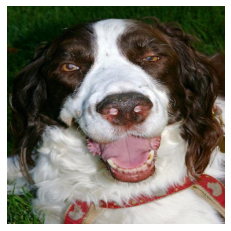

In [26]:
for step, (images, _) in enumerate(imagenet_ds_test):
    if step != 23:
        continue
    batch = images.cpu().detach().numpy()
    batch = np.moveaxis(batch, 0, -1)
    plt.axis('off')
    plt.imshow(batch)
    plt.imsave('dog.jpg', batch)
    break

images.shape: torch.Size([512, 112, 112])
images.shape: torch.Size([1024, 56, 56])
images.shape: torch.Size([2048, 28, 28])
images.shape: torch.Size([4096, 14, 14])


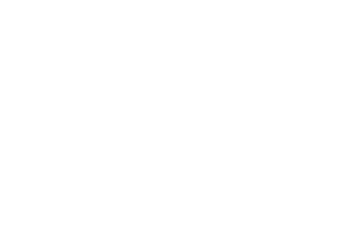

In [27]:
for step, (images, _) in enumerate(block_1):

    if step != 23:
      continue
    print('images.shape:', images.shape)

    image = images.cpu().detach().numpy()
    image = np.moveaxis(image, 0, -1)
    np.save('block1.npy', image)

    break

for step, (images, _) in enumerate(block_2):
    if step != 23:
      continue
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    np.save('block2.npy', image)
    plt.axis('off')
    
    break

for step, (images, _) in enumerate(block_3):
    if step != 23:
      continue
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    np.save('block3.npy', image)
    plt.axis('off')

    break

for step, (images, _) in enumerate(block_4):
    if step != 23:
      continue
    print('images.shape:', images.shape)
    image = images.cpu().detach().numpy()

    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)
    np.save('block4.npy', image)
    plt.axis('off')

    break